# State 477 Final Presentation
## Introduction:
Using data about health, economic and demographic characteristics measured at the county level in
the US, we aim to predict the proportion of counties with poor health statuses. The y variable we have selected is the Proportion of county that has a poor health status. We will begin with doing exploratory data analysis, followed by feature selection, preprocessing, model training, and model evaluation. 

* Ahmed Ahmed
* December 2020


In [1]:
# This is a code cell. Because it is marked "skip" it will be evaluated but not placed in the reveal.js presentation.
# Read in all the libraries and data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

os.chdir('C:/Users/Ahmed/OneDrive - PennO365/Sophomore Fall/STAT477') 
county_data = pd.read_csv("Final_Data.csv", index_col='Row.Label')

<IPython.core.display.Javascript object>

# Summary Statistics
We will look at a the summary statistics for the county data that we have downloaded. We want to start getting a feel for what is in our dataset, and any preprocessing we must do in order to begin working with the dataset. I have selected to work with health index as the y variable. 

1. Does the Dataset have null values? (i.e is the data clean)
2. Does the Dataset have column types that aren't numbers?
3. What is the shape of our date?
4. What does our data look like?


In [2]:
print("The data has {} Rows and {} Columns \n".format(county_data.shape[0], county_data.shape[1]))
print("Columns: %s \n" % county_data.columns)

# columns with no set type will have to be cast to a numerical type
categorical_columns = county_data.loc[:, county_data.dtypes == object].columns
print("Columns with no set type: \n%s\n" % categorical_columns)
missing_values = county_data.isnull().sum()
print("Percentage of data missing: %f percent \n" % (missing_values.sum() / np.product(county_data.shape) * 100))
print(county_data.describe())
print("\n")

The data has 2715 Rows and 26 Columns 

Columns: Index(['Five-digit.FIPS.Code', 'State.FIPS.Code', 'County.FIPS.Code',
       'State.Abbreviation', 'CountyName', 'Poor.Health',
       'Election.Results.2016', 'Uninsured',
       'Primary.Care.Physicians.Per.1000', 'Mental.health.providers.Per.1000',
       'Adult.Obesity', 'Proportion.of.Smokers', 'High.School.Graduation',
       'Insufficient.Sleep', 'Physical.Inactivity', 'Excessive.Drinking',
       'Median.Household.Income', 'Severe.Housing.Problems', 'Unemployment',
       'Food.Insecurity.Quintile', 'Income.Inequality.Quartile',
       'Percent.Rural', 'Over.65', 'Percent.Females', 'Life.Expectancy',
       'Population'],
      dtype='object') 

Columns with no set type: 
Index(['State.Abbreviation', 'CountyName', 'Election.Results.2016',
       'Food.Insecurity.Quintile', 'Income.Inequality.Quartile'],
      dtype='object')

Percentage of data missing: 0.000000 percent 

       Five-digit.FIPS.Code  State.FIPS.Code  County.FIPS.

# Goals
 
* The data looks very clean and there does not seem to be a need for any preprocessing
* Predict Health of Counties based on the features 
* Find the relative importance of the given features and what seems to impact health the most
* Find additional insights into key differences between health of counties and states and any correlation between them

## Questions
* How can we improve the healthiness of Counties?
* What things do we think has an effect but doesnt?
* Where are we lacking and where can we offer support to counties?

Finding the importance of features allows us to offer advice to organizations such as the government to improve the health of states. It allows them to be able to offer assistance in key areas that have the most impact. Instead of uniformly distributing help, we aim to generate insight into where most of our resources should be put into in order to generate the most positive impact.

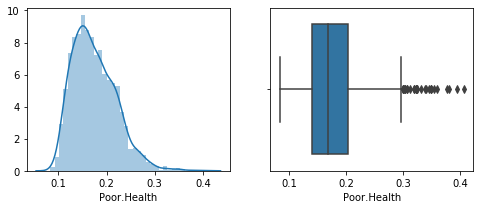

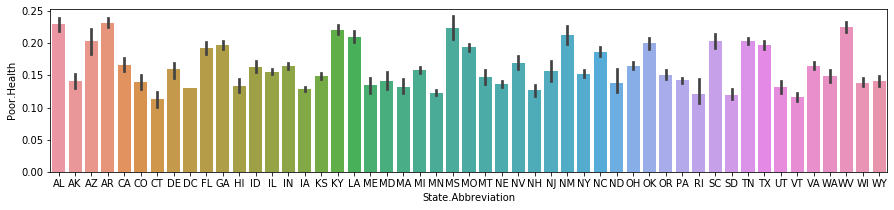

In [3]:
plt.figure(figsize=(8,3))
plt.subplot(121)
sns.distplot(county_data['Poor.Health'])
plt.subplot(122)
sns.boxplot(county_data['Poor.Health'])
plt.figure(figsize=(15,3))
sns.barplot(data=county_data, x='State.Abbreviation', y='Poor.Health')
plt.show()

In [4]:
print("Average Health: {}\n".format(county_data['Poor.Health'].mean())) 
mean_health_states = county_data.groupby('State.Abbreviation')['Poor.Health'].mean()
mean_health_states = mean_health_states.sort_values(ascending=False)
print("States with the highest average proportion of unhealthiness: \n{}\n".format(mean_health_states[:5]))
print("States with the lowest average proportion of unhealthiness: \n{}\n".format(mean_health_states.tail(5)))

Average Health: 0.17438471454880308

States with the highest average proportion of unhealthiness: 
State.Abbreviation
AR    0.231626
AL    0.229694
WV    0.225047
MS    0.223572
KY    0.221119
Name: Poor.Health, dtype: float64

States with the lowest average proportion of unhealthiness: 
State.Abbreviation
MN    0.123187
RI    0.121780
SD    0.119667
VT    0.116242
CT    0.113317
Name: Poor.Health, dtype: float64



# Graphical Insights

* The average proportion of unhealthy people per state is around 17%
* The distribution of health is skewed to the right, meaning that there are some counties with as much as 40% unhealthiness  
* Perhaps looking at differences between States with the most unhealthiness vs least would give us some further insights into what is important in predicting health
* We should expect to see an inverse relationship in important features of variables between healthy and unhealthy states. For example if an unhealthy state has a high proportion of excessive drinking, then if excessive drinking is an important feature, we should expect to see a low proportion of excessive drinking in healthy states
* In order to determine which features seem to be inversely proportional, we will use two way interactions for Obesity, Proportion of Smokers, Sleep, Physical Inactivity, Excessive Drinking, Unemployment, Food Insecurities Quintile, Median HouseHold Income, and Life expectancy
* Intuitively, we expect that these columns will have the most significance when it comes to predicting healthiness


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'
unhealthy_states = list(mean_health_states[:5].index)
healthy_states = list(mean_health_states.tail(5).index)
county_data_unhealthy = county_data[county_data['State.Abbreviation'].isin(unhealthy_states)]
county_data_healthy = county_data[county_data['State.Abbreviation'].isin(healthy_states)]
county_data_unhealthy['State.Abbreviation'] = 'Unhealthy'
county_data_healthy['State.Abbreviation'] = 'Healthy'
df = pd.concat([county_data_unhealthy, county_data_healthy], axis=0)

cont_features = ['Adult.Obesity', 'Life.Expectancy', 'Proportion.of.Smokers', 'Insufficient.Sleep', 
                 'Physical.Inactivity', 'Excessive.Drinking','Unemployment', 'Median.Household.Income']
cat_features = ['Food.Insecurity.Quintile']

county_data_unhealthy = county_data_unhealthy[cont_features]
county_data_healthy = county_data_healthy[cont_features]
diff_means = ((county_data_unhealthy.mean() - county_data_healthy.mean()) / county_data_unhealthy.mean()) * 100
print(diff_means.sort_values())

Excessive.Drinking        -50.994800
Median.Household.Income   -38.436426
Life.Expectancy            -7.124127
Adult.Obesity              16.796537
Insufficient.Sleep         24.441268
Unemployment               27.969742
Proportion.of.Smokers      30.215447
Physical.Inactivity        31.301100
dtype: float64


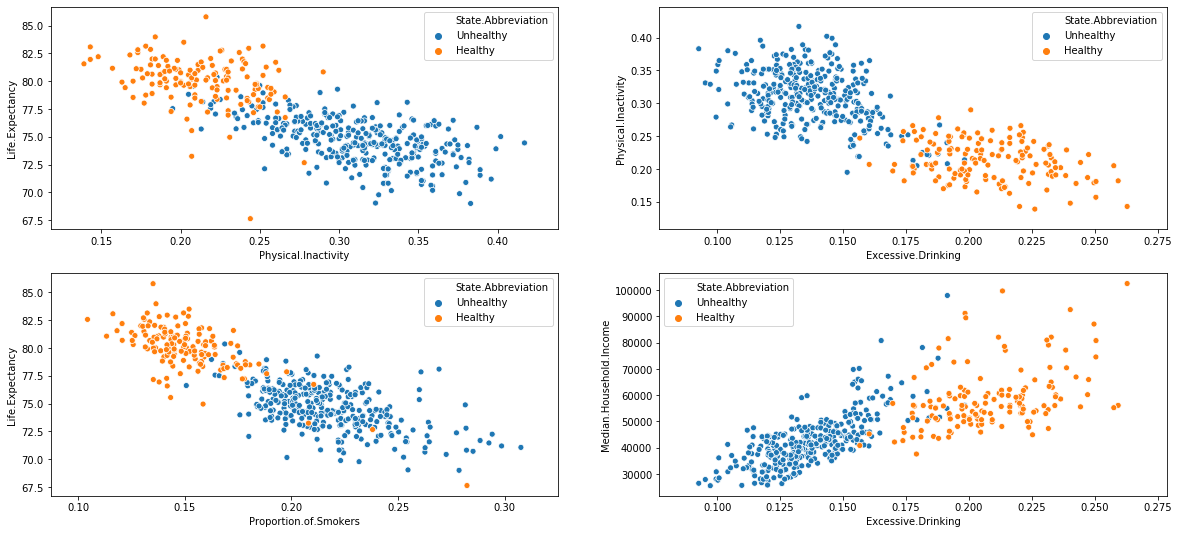

In [6]:
i = 1
fig = plt.figure(figsize=(20,9))
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='Physical.Inactivity', y='Life.Expectancy', hue='State.Abbreviation')
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Excessive.Drinking', y='Physical.Inactivity', hue='State.Abbreviation')
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Proportion.of.Smokers', y='Life.Expectancy', hue='State.Abbreviation')
plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x='Excessive.Drinking', y='Median.Household.Income', hue='State.Abbreviation')
plt.show()

# Correlation Between Features of Healthy and Unhealthy States
## It seems that there are some interesting correlation between the features
* Higher life expectancy seems to be negatively correlated with physical inactivity 
* Healthier states have higher levels of excessive drinking which seem to be correlated with a lower physical inactivity
* Life expectancy for healthier states are get higher as the proportion of Smokers decreases
* Life expectancy for unhealthy states get lower as proportion of smokers increase
* States with more median income seems to have much higher levels of excessive drinking

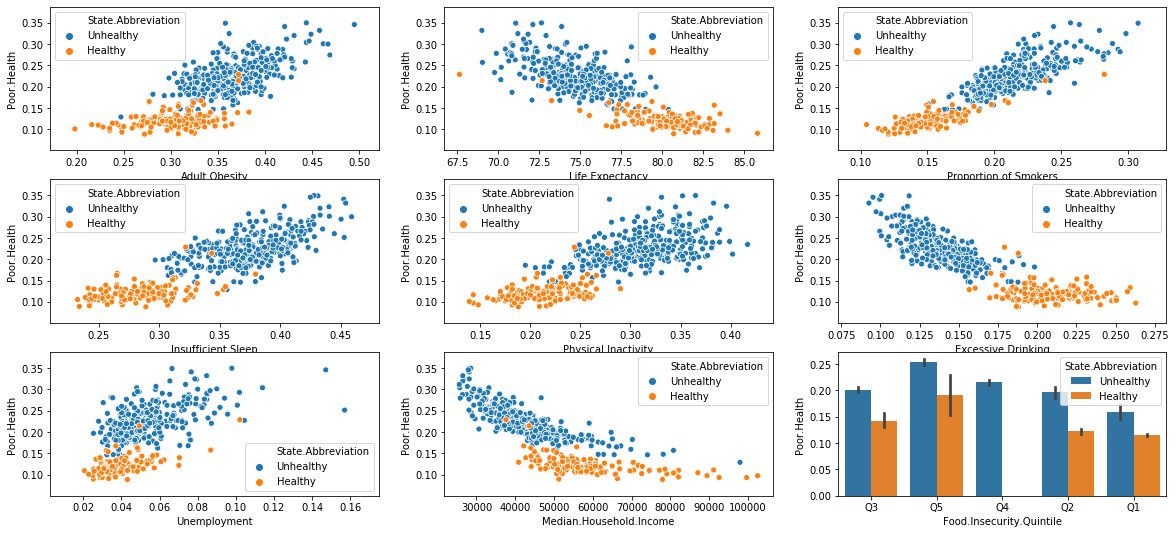

In [7]:
fig = plt.figure(figsize=(20,9))
n, m, i = 3, 3, 1  # number of rows
for col in cont_features:
    plt.subplot(n, m, i)
    sns.scatterplot(data=df, x=col, y='Poor.Health', hue='State.Abbreviation')
    i += 1 
    
for col in cat_features:
    plt.subplot(n, m, i)
    sns.barplot(x=col, y='Poor.Health', hue='State.Abbreviation', data=df)
    i += 1
plt.show()  

# State Level Summary

* As we predicted, all of the features (Obesity, Proportion of Smokers, Sleep, Physical Inactivity, Excessive Drinking, Unemployment, Food Insecurities Quintile, Income Inequality Quartile, and Life expectancy) vary greatly between states that are proportionaly healthier and those that are not

* For the Relplots, it seems like a singular linear line could be drawn to seperate the two types of states, which is a clear indication that these features are important in predicting Poor Health

* On average Unhealthy States:
  * Drink 51% less than healthy States
  * Are expected to live 7% less than healthy States
  * Are about 16% more obese than healthy States
  * Get about 24% less sleep than healthy States
  * Have 27% more unemployment than healthy States
  * 30% more of them are smokers than healthy States
  * Are 31% more inactive than healthy States
  * Have a much larger income inequality than healthy States
  * Have much more Food Insecurity than healthy States

In [8]:
cont = list(county_data.loc[:, county_data.dtypes != object].columns)
cat = ['Food.Insecurity.Quintile', 'Income.Inequality.Quartile']
cont.remove('Poor.Health')
Xcts = county_data[cont]
Xcat = county_data[cat]
Xcat = pd.get_dummies(Xcat)
X = pd.merge(Xcts, Xcat, left_index = True, right_index = True)
y = county_data['Poor.Health']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1940)

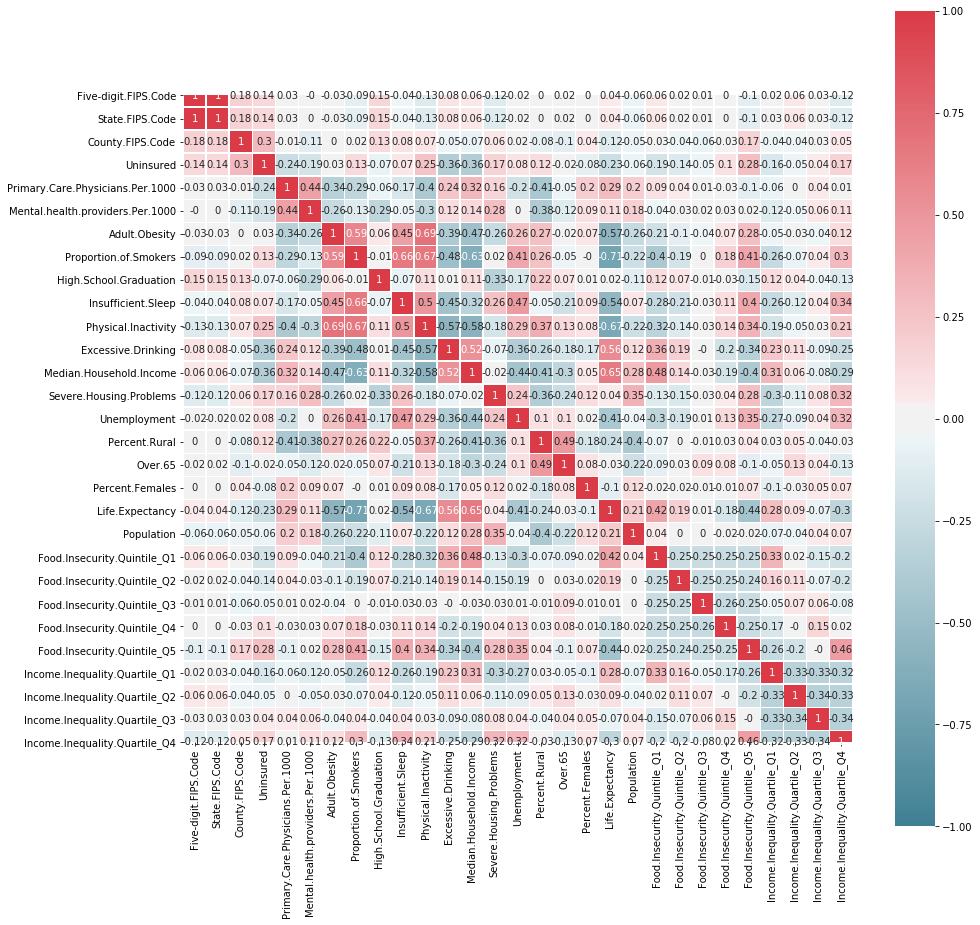

In [9]:
corr = X.corr().round(2)

correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.8:
            colname = corr.columns[i]
            correlated_features.add(colname)
            
X.drop(correlated_features, 1, inplace=True)

# Define custom colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, annot=True)

# Feature Correlation

We checked to see if features that will be used to train the model are correlated. The goal of doing this is to drop columns that are highly correlated (as defined by a correlation of .8) such that when we train the model, we do not double count the same variable. The only thing that seems to be correlated is the State.FIPS.Code which was dropped from the feature set. 

Best alpha with CCP Path is : 2.560004010024125e-06


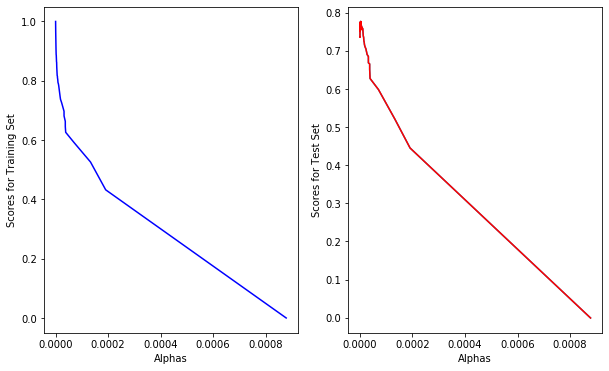

In [15]:
model = tree.DecisionTreeRegressor(random_state=0)
alphas = model.cost_complexity_pruning_path(X_train, y_train).ccp_alphas
# alphas = np.linspace(0, .00005, 100)
scores_test = []
scores_train = []

for alpha in alphas:
    model = tree.DecisionTreeRegressor(ccp_alpha=alpha, random_state=0)
    model.fit(X_train, y_train)
    scores_test.append(model.score(X_test, y_test))
    scores_train.append(model.score(X_train, y_train))

best_alpha = alphas[pd.Series(scores_test).idxmax()]    

plt.figure(figsize=(10, 6))
print("Best alpha with CCP Path is : {}".format(best_alpha))
plt.subplot(121)
sns.lineplot(alphas, scores_train, color='blue')
plt.xlabel('Alphas')
plt.ylabel('Scores for Training Set')
plt.subplot(122)
sns.lineplot(alphas, scores_test)
plt.xlabel('Alphas')
plt.ylabel('Scores for Test Set')
sns.lineplot(alphas, scores_test, color='red')

In [11]:
model = tree.DecisionTreeRegressor(ccp_alpha=best_alpha, random_state=0)
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Decision Tree Regressor Score is: {}%".format(round(score, 3) * 100))
print("Semi Optimal Depth of Tree: {}".format(model.get_depth()))
print("Semi Optimal Number of Leaves: {}".format(model.get_n_leaves()))
print(pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)[:10])
tree_rules = tree.export_text(model, feature_names=list(X_train.columns))
print(tree_rules)

Decision Tree Regressor Score is: 77.7%
Semi Optimal Depth of Tree: 9
Semi Optimal Number of Leaves: 68
Median.Household.Income    0.578767
Life.Expectancy            0.106184
Insufficient.Sleep         0.072138
Proportion.of.Smokers      0.049839
Uninsured                  0.044006
Over.65                    0.037868
Excessive.Drinking         0.031048
Unemployment               0.027611
Severe.Housing.Problems    0.020395
Five-digit.FIPS.Code       0.007913
dtype: float64
|--- Median.Household.Income <= 44736.50
|   |--- Median.Household.Income <= 36995.50
|   |   |--- Over.65 <= 0.15
|   |   |   |--- Unemployment <= 0.09
|   |   |   |   |--- Five-digit.FIPS.Code <= 38102.00
|   |   |   |   |   |--- value: [0.27]
|   |   |   |   |--- Five-digit.FIPS.Code >  38102.00
|   |   |   |   |   |--- value: [0.32]
|   |   |   |--- Unemployment >  0.09
|   |   |   |   |--- value: [0.38]
|   |   |--- Over.65 >  0.15
|   |   |   |--- Insufficient.Sleep <= 0.39
|   |   |   |   |--- Excessive.Drink

[Text(465.0, 528.5, 'Median.Household.Income <= 44736.5\nmse = 0.002\nsamples = 1900\nvalue = 0.174'),
 Text(232.5, 377.5, 'Median.Household.Income <= 36995.5\nmse = 0.002\nsamples = 610\nvalue = 0.217'),
 Text(116.25, 226.5, 'Over.65 <= 0.149\nmse = 0.002\nsamples = 165\nvalue = 0.251'),
 Text(58.125, 75.5, '\n  (...)  \n'),
 Text(174.375, 75.5, '\n  (...)  \n'),
 Text(348.75, 226.5, 'Insufficient.Sleep <= 0.309\nmse = 0.001\nsamples = 445\nvalue = 0.205'),
 Text(290.625, 75.5, '\n  (...)  \n'),
 Text(406.875, 75.5, '\n  (...)  \n'),
 Text(697.5, 377.5, 'Life.Expectancy <= 78.182\nmse = 0.001\nsamples = 1290\nvalue = 0.154'),
 Text(581.25, 226.5, 'Proportion.of.Smokers <= 0.18\nmse = 0.001\nsamples = 580\nvalue = 0.172'),
 Text(523.125, 75.5, '\n  (...)  \n'),
 Text(639.375, 75.5, '\n  (...)  \n'),
 Text(813.75, 226.5, 'Uninsured <= 0.118\nmse = 0.001\nsamples = 710\nvalue = 0.138'),
 Text(755.625, 75.5, '\n  (...)  \n'),
 Text(871.875, 75.5, '\n  (...)  \n')]

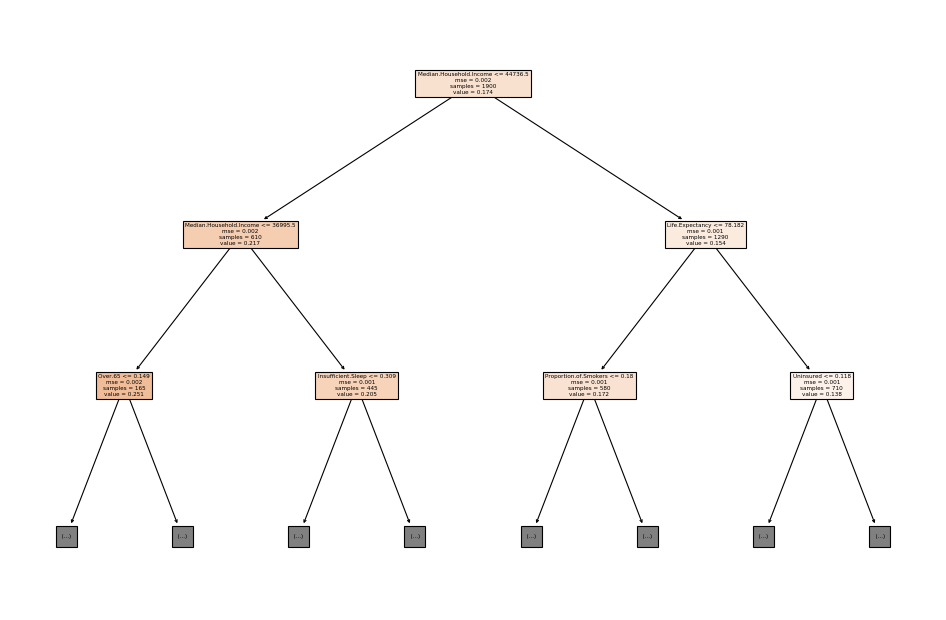

In [12]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor = 'w', edgecolor='k')
tree.plot_tree(model, filled=True, max_depth=2, feature_names=X_train.columns)

# Tree Interpretation

Given the questions of initial interest concerning feature importance and prediction of health, we can see from the splits of the tree:

    * The most important Split is the median household income >= 44736.50 which reduced the variance by about .2 
    * From there, there are a few different splits concerning Life Expectancy, Insufficient Sleep, Proportion of Smokers,and Unisured which all reduce variance except Over 65. 
    
What we can understand from the decision tree is that increasing household income is the single best way to improve the health of states. Generally, just giving people more money is an ambigious action. What are people buying such that there health is improved so much? Is it better healthcare? Better food? Better Lifestyle? This is not clear in the tree. However, what we can do is recommend that people get more sleep, smoke less, and get insured. We should focus less on Mental health and primary care physicians, and instead focus on helping people improve their lifestyle habits.

In [13]:
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(X_train, y_train)
score = rf_model.score(X_test, y_test)
print("Random Forest Regressor Score is: {}%".format(round(score, 3) * 100))
print(pd.Series(rf_model.feature_importances_, X_train.columns).sort_values(ascending=False)[:20])

Random Forest Regressor Score is: 89.4%
Median.Household.Income             0.542277
Life.Expectancy                     0.090002
Insufficient.Sleep                  0.078125
Proportion.of.Smokers               0.055572
Uninsured                           0.050466
Over.65                             0.033171
Excessive.Drinking                  0.032755
Severe.Housing.Problems             0.019723
Unemployment                        0.018219
Physical.Inactivity                 0.009629
Five-digit.FIPS.Code                0.009601
Adult.Obesity                       0.006866
Food.Insecurity.Quintile_Q1         0.006855
Percent.Rural                       0.006385
Population                          0.005679
High.School.Graduation              0.005302
County.FIPS.Code                    0.005150
Mental.health.providers.Per.1000    0.004782
Primary.Care.Physicians.Per.1000    0.004449
Percent.Females                     0.004348
dtype: float64


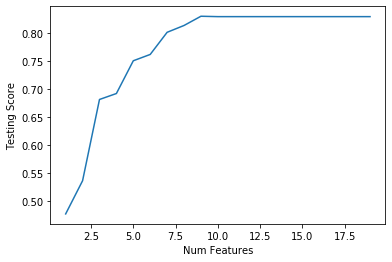

Optimal amount of features to use for linear regression: 8
Best score: 82.97%


In [14]:
b = pd.Series(rf_model.feature_importances_, X_train.columns).sort_values(ascending=False)[:10]
a = sklearn.linear_model.LinearRegression()
a.fit(X_train[b.index], y_train)

scores = []

for i in range(1, 20):
    a = sklearn.linear_model.LinearRegression()
    cols = b.index[:i]
    a.fit(X_train[cols], y_train)
    scores.append(a.score(X_test[cols], y_test))

sns.lineplot(list(range(1, 20)), scores)
plt.xlabel("Num Features")
plt.ylabel("Testing Score")
plt.show()
print("Optimal amount of features to use for linear regression: {}".format(scores.index(max(scores))))
print("Best score: {}%".format(round(max(scores), 4) * 100))

# Linear Model (Similar Procedure to Relaxed Lasso)

I made a graph of the number of features necessary to give the best predictive performance on the Poor Health data by training 20 different linear models each with a different amount of features. The features were ranked according to the feature importance of the Random Forest trained.  As the number of features increases from 8, there are minimal improvements, thus signifying that there are only about 8 important features that determine the model. The final accuracy of the model was only about 83% which signifies that about 83% of the variation can be explained by the first 8 features. In the world of Data Science this is generally an accepted result, however we could always improve on this. The random forest is one such example of improvement achieved by bagging multiple decision trees and we had about 89% accuracy. 

# Conclusions

* Using the Most accuracte model which is the Random Forest and the optimal number of features
    * Median Household Income determines about 54.2% of Healthiness
    * Life Expectancy determines about 9% of Healthiness
    * Insuficient sleep determines about 7.8% of Healthiness
    * Propotion of Smokers determines about 5.5% of Healthiness
    * Uninsured determines about 5% of Healthiness
    * Excessive Drinking determines about and being over 65 determine about 3.3% each of healthiness 
    * Severe Housing problems determines about 2% of healthiness
    * Variables such as Severe Housing Problems, Unemployment, Physical Inactivity, Primary care physicians, 
        Mental health Provideres, and Graduation rate seem to have no effect
    * There is variability in feature importance across the random forest and decision tree, but this is to be expected
    * We improved upon the individual decision regressor by introducing bagging to aggregate individual regressors which improved our model accuracy 